In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.data_processing import *
from utils.metrics import PRCurvePlotter, LossPlotter, ROCCurvePlotter
from sys import getsizeof
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import rcParams
import os

### Note: use np.ravel_multi_index and np.unravel_index with get_item for datasets

In [2]:
# def __get_item__():
index = 34
t_size, x_size, y_size = 20, 5, 10
t,x,y = np.unravel_index(index, (t_size, x_size, y_size))
np.ravel_multi_index(multi_index=(t,x,y),dims=(t_size, x_size, y_size))

34

# Generic Dataset and DataLoader and training a logistic regression

In [3]:
data_dim_str = "MOCK-DATA" # needs to exist
model_name = "LINEAR-MOCK-MODEL" # needs to be created

data_folder = f"./data/processed/{data_dim_str}/"
model_folder = data_folder + f"models/{model_name}/"

os.makedirs(data_folder, exist_ok=True)
os.makedirs(model_folder, exist_ok=True)

Save data in the folling directory:
```
/data/processed/{data_dims}/models/{model_name}/
```
`info.json`
```
{
createdOn:"20190810T1416",
updateOn:"20190810T1416",
timeToTrain:"120min",

batch_size:10,
shuffle:false,
num_workers:4,

}
```

`info.json`

In [4]:
from torch import nn, optim
class LinearRegressor(nn.Module):
    def __init__(self, input_size=10, n_classes=2):
        super(LinearRegressor, self).__init__()

        self.linear = nn.Linear(input_size, n_classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.activation(self.linear(x))
        

        return out    

import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """
    Characterizes a dataset for PyTorch
    """
    def __init__(self, feats, labels):
        'Initialization'
        self.labels = labels
        self.feats = feats

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.feats)

    def __getitem__(self, index):
        'Generates one sample of data'
        X = self.feats[index]
        y = self.labels[index]

        return X, y    

In [1]:
from utils.configs import BaseConf

In [13]:
conf = BaseConf()

In [14]:
d = {**conf.__dict__}

In [15]:
d["seed"] = -202

SyntaxError: invalid syntax (<ipython-input-21-897c9e1f3a74>, line 1)

In [5]:
# generating the data sample
N,d = 5000, 50
n_classes = 2
bias = -0.05
feats = np.random.randn(N,d) + bias
labels = np.array(0.5*(np.sign(np.sum(feats,axis=1)) + 1),dtype=int)


# print(labels)
print(f"Invereted Class Weights: {inv_weights(labels)}")

Invereted Class Weights: [0.3632 0.6368]


In [6]:
# todo parse conf or args
class Args:  # can either be args or conf
    seed = 3
    resume = False
    early_stopping = False
    use_weighted_sampler = True
    use_cuda = False

    # data related hyper-params
    val_ratio = 0.1
    tst_ratio = 0.2

    # training parameters
    max_epochs = 10
    batch_size = 80
    shuffle = False
    num_workers = 4


args = Args()

In [7]:
from torch.utils.data.sampler import WeightedRandomSampler


use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(args.seed)
    pin_memory = True # makes RAM -> GPU transfers quicker
    print("using cuda")
else:    
    torch.manual_seed(args.seed)
    pin_memory = False
    
device = torch.device("cuda:0" if use_cuda else "cpu")

val_size = int(len(feats)*args.val_ratio)
tst_size = int(len(feats)*args.tst_ratio)

trn_indx = (0,len(feats)-tst_size-val_size)
val_indx = (trn_indx[1],len(feats)-tst_size)
tst_indx = (val_indx[1],len(feats))


training_set = CustomDataset(feats[trn_indx[0]:trn_indx[1]],labels[trn_indx[0]:trn_indx[1]])
validation_set = CustomDataset(feats[val_indx[0]:val_indx[1]],labels[val_indx[0]:val_indx[1]])
testing_set = CustomDataset(feats[tst_indx[0]:tst_indx[1]],labels[tst_indx[0]:tst_indx[1]])

training_weights = map_to_weights(labels[trn_indx[0]:trn_indx[1]])
validation_weights = map_to_weights(labels[val_indx[0]:val_indx[1]])
testing_weights = map_to_weights(labels[tst_indx[0]:tst_indx[1]])

if args.use_weighted_sampler:
    train_sampler = WeightedRandomSampler(weights=training_weights,
                                          num_samples=len(training_weights),
                                          replacement=False)
    validation_sampler = WeightedRandomSampler(weights=validation_weights,
                                               num_samples=len(validation_weights),
                                               replacement=False)
    testing_sampler = WeightedRandomSampler(weights=testing_weights,
                                            num_samples=len(testing_weights),
                                  replacement=False)
else:   
    train_sampler = None
    validation_sampler = None
    testing_sampler = None


training_generator = DataLoader(dataset=training_set,
                                batch_size=args.batch_size,
                                shuffle=args.shuffle,
                                num_workers=args.num_workers,
                                pin_memory=pin_memory,
                                sampler=train_sampler)

validation_generator = DataLoader(dataset=validation_set,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle,
                                  num_workers=args.num_workers,
                                  pin_memory=pin_memory,
                                  sampler=validation_sampler)

testing_generator = DataLoader(dataset=testing_set,
                               batch_size=args.batch_size,
                               shuffle=args.shuffle,
                               num_workers=args.num_workers,
                               pin_memory=pin_memory,
                               sampler=testing_sampler)

In [16]:
# model related hyper-params


model = LinearRegressor(input_size=d,n_classes=n_classes)
model.to(device)

loss_function = nn.CrossEntropyLoss()


trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []


optimiser = optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-8)
if args.resume:
    # load model and optimiser states
    model.load_state_dict(torch.load(model_folder +"model.pth"))
    optimiser.load_state_dict(torch.load(model_folder + "optimiser.pth"))
    # load losses
    losses_zip = np.load(model_folder + "losses.npz")
    all_val_loss = losses_zip["all_val_loss"].tolist()
    val_loss = losses_zip["val_loss"].tolist()
    trn_loss = losses_zip["trn_loss"].tolist()
    all_trn_loss = losses_zip["all_trn_loss"].tolist()
    val_loss_best = float(losses_zip["val_loss_best"])

    

# Loop over training data
for epoch in range(3):
    # Training loop
    tmp_trn_loss = []
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        out = model(local_batch.float())

        loss = loss_function(out, local_labels)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    trn_loss.append(np.mean(tmp_trn_loss))    

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for local_batch, local_labels in validation_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            out = model(local_batch.float())

            loss = loss_function(out, local_labels)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])
    val_loss.append(np.mean(tmp_val_loss))
    
    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_folder + "model_best.pth")
        torch.save(optimiser.state_dict(), model_folder + "optimiser_best.pth")
    
    # model has been overfitting stop maybe?
    if args.early_stopping and epoch != 0 and val_loss[-1] > val_loss[-2]: # average of val_loss has increase - starting to overfit
        print("Overfitting has taken place - stopping early") # change prints to logs
        break

    
    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_folder + "model.pth")
    torch.save(optimiser.state_dict(), model_folder + "optimiser.pth")
    np.savez_compressed(model_folder + "losses.npz",
                    all_val_loss=all_val_loss,
                    val_loss=val_loss,
                    trn_loss=trn_loss,
                    all_trn_loss=all_trn_loss,
                    val_loss_best=val_loss_best)

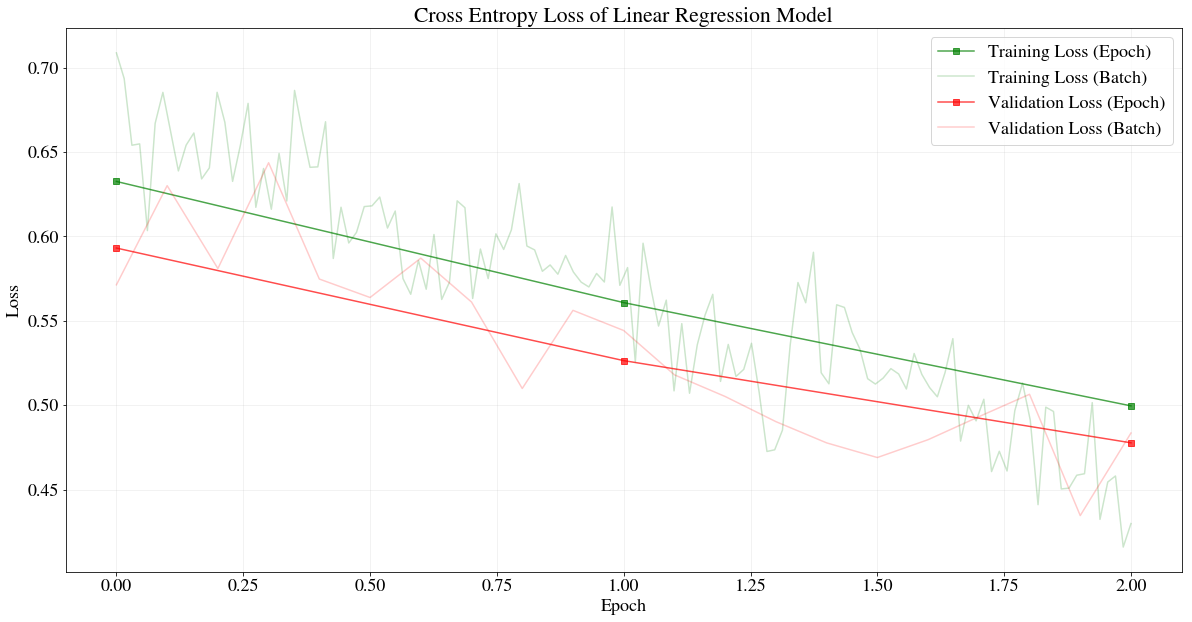

In [17]:
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss, val_loss, all_val_loss)
loss_plotter.savefig(model_folder + "plot_train_val_loss.png")

In [18]:
for local_batch, local_labels in testing_generator:
    print(inv_weights(local_labels))

[0.5875 0.4125]
[0.4875 0.5125]
[0.525 0.475]
[0.4125 0.5875]
[0.3875 0.6125]
[0.3875 0.6125]
[0.3625 0.6375]
[0.375 0.625]
[0.3875 0.6125]
[0.275 0.725]
[0.275 0.725]
[0.2125 0.7875]
[0.025 0.975]


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
# Evaluation on test set
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    for local_batch, local_labels in testing_generator: # loop through is set does not fit in batch
        y_true.extend(local_labels.tolist())
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        out = model(local_batch.float())
        out = F.softmax(out,dim=1)
        out_label = torch.argmax(out,dim=1)
        y_pred.extend(out_label.tolist())
        out_proba = out[:,1] # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())

        
acc = accuracy_score(y_true,y_pred)
auc = roc_auc_score(y_true,probas_pred)
ap = average_precision_score(y_true,probas_pred)
print(f"Accuracy:\t\t {acc:.4f}")
print(f"ROC AUC:\t\t {auc:.4f}")
print(f"Average Prevision:\t {ap:.4f}")

np.savez_compressed(model_folder + "evaluation_results.npz",
                    acc=acc,
                    auc=auc,
                    ap=ap,
                    y_true=y_true,
                    y_pred=y_pred,
                    probas_pred=probas_pred)     

pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="Model A")
pr_plotter.add_curve(y_true, np.roll(probas_pred,1), label_name="Model B")
pr_plotter.savefig(model_folder + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="Model A")
roc_plotter.add_curve(y_true, np.roll(probas_pred,10), label_name="Model B")
roc_plotter.savefig(model_folder + "plot_roc_cruve.png")

acc: 0.858


Accuracy:		 0.8580
ROC AUC:		 0.9354
Average Prevision:	 0.8971


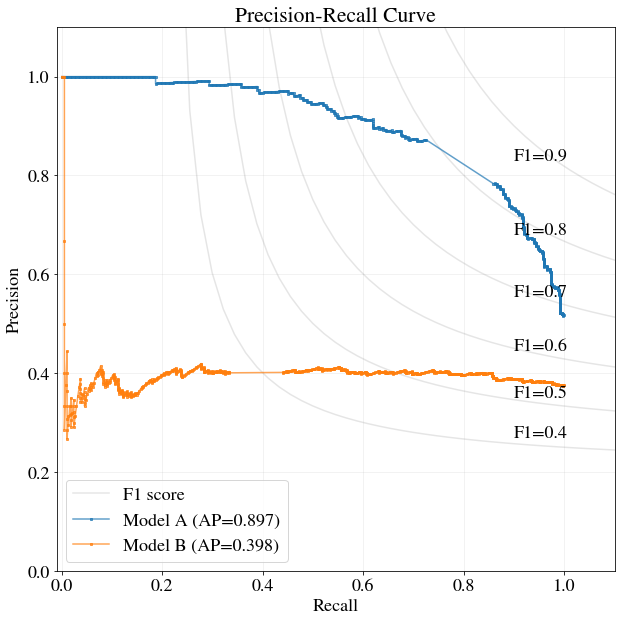

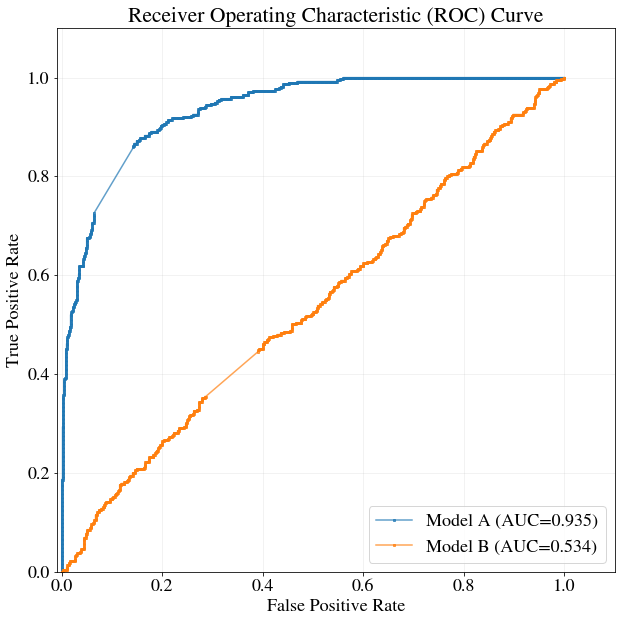

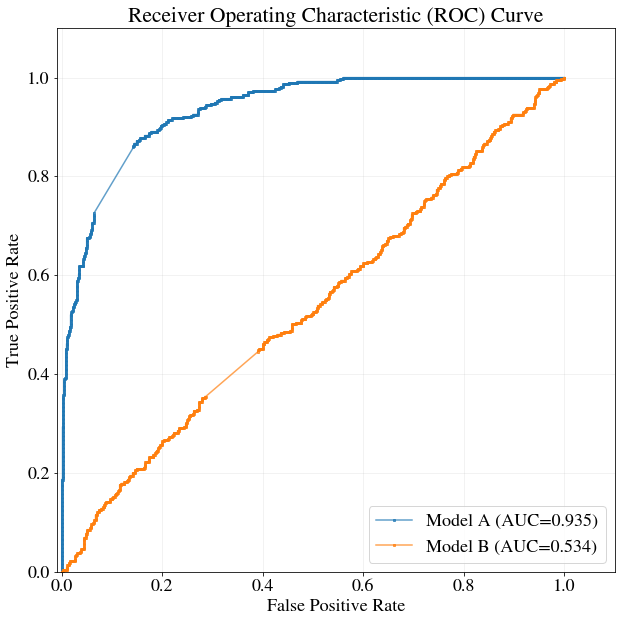

## Todo have AUC per fram over time 
Use `auc = roc_auc_score(y_true, y_score)`
